<b>Experimentando con Algoritmos Geneticos para buscar frases</b> 

In [2]:
import sys
import time
import numpy as np
import random
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import heapq

## Estructura de individuo 

In [3]:
 """ Clase que implementa el individuo y sus operadores. El cromosoma de un individuo es una lista de caracteres,
       cada elemento de la lista es un gen cuyos alelos (caracteres) posibles se indican en allele_pool"""

class Individual:   
    
    def __init__(self, chromosome, allele_pool):  # el constructor recibe el cromosoma  y el pool de alelos posibles
        self.chromosome = chromosome[:]
        self.allele_pool = allele_pool
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
        
    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:], allele_pool)
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:], allele_pool)
        return [ind1, ind2]   
    
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1, allele_pool)
        ind2 = Individual(chromosome2, allele_pool)
        return [ind1, ind2] 

    def mutate_position(self):
        "Cambia aleatoriamente el alelo de un gen."
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(mutated_chromosome)) 
        newAllele = allele_pool[random.randrange(0,len(allele_pool))]
        mutated_chromosome[mutGene] = newAllele
        return Individual(mutated_chromosome, allele_pool)
        
    def mutate_swap(self):
        "Escoge dos genes e intercambia sus alelos"
        mutated_chromosome = deepcopy(self.chromosome)
        mutGen1 = random.randrange(0,len(mutated_chromosome))
        mutGen2 = random.randrange(0,len(mutated_chromosome))
        temp = mutated_chromosome[mutGen1]
        mutated_chromosome[mutGen1] = mutated_chromosome[mutGen2]
        mutated_chromosome[mutGen2] = temp
        return Individual(mutated_chromosome, allele_pool)

Funcion para iniciar una Poblacion tipo string

In [4]:
def init_population(pop_number, chromosome_size, allele_pool):
    
    num_alleles = len(allele_pool)
    population = []
    for i in range(pop_number):
        new_chromosome = [allele_pool[random.randrange(0, num_alleles)] for j in range(chromosome_size)]
        population.append( Individual(new_chromosome, allele_pool) )
    return population

Funcion para mostrar una población y su fitnes

In [5]:
def display(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([''.join(population[i].chromosome),population[i].fitness])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness']
    return data

## Funcion de Aptitud

Funcion para evaluar toda una población de individuos con un "Target_string" especificado

In [6]:
def matching_characters(chromosome, target_string):
    """Retorna el fitness de un cromosoma como el numero de caracteres coincidentes con la frase objetivo"""
    fitness = 0 # initialize fitness to 0
    for i in range(len(chromosome)):
        # suma 1 por cada coincidencia entre chromosome y target_string
        if chromosome[i] == target_string[i]:
            fitness += 1
    return fitness

In [7]:
def matching_characters2(chromosome, target_string): #Itera sobre 2 listas
    """Retorna el fitness de un cromosoma como el numero de caracteres coincidentes con la frase objetivo"""
    fitness = 0 # initialize fitness to 0
    #Si el valor actual = esperado entonces suma 1. Coincidencia total= len(target)
    fitness = sum(1 for actualIndividuo,expected in
                  zip(''.join(chromosome),target_string) 
                  if actualIndividuo==expected)
    return fitness

<b>Funcion para evaluar toda una población de individuos con la funcion de fitnes especificada</b>

In [8]:
def evaluate_population(population, fitness_fn, target_string):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome, target_string)

## Selecciona los padres mediante operadores: Ruleta/ Torneo

### Ruleta

In [9]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

### Torneo

In [10]:
def select_parents_torneo(population,size_torneo):
    
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

## Seleccion de sobrevivientes por Ranking

<b>Funcion que selecciona sobrevivientes para la sgte generacion, dada la poblacion actual y poblacion de hijos</b>

In [11]:
def select_survivors(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

## Algoritmo Genetico
Recibe una poblacion inicial, funcion de fitness, numero de generaciones (ngen), metodoSeleccion (ruleta/torneo), size_torneo, taza de mutación (pmut), operador de cruzamiento (crossover) y operador de mutacion (mutation)

In [12]:
def genetic_algorithm(population, fitness_fn, target_string, ngen, metodoSeleccion, size_torneo, pmut, crossover, mutation):

    popsize = len(population)
    evaluate_population(population, fitness_fn, target_string)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # mejor fitness
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion

        ## Selecciona las parejas de padres para cruzamiento 
        mating_pool = []
        if metodoSeleccion=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        elif metodoSeleccion=="torneo" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,size_torneo)) 
                    
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "position":
                    offspring_population[i] = offspring_population[i].mutate_position()   # mutacion de una posicion
                elif mutation == "swap":
                    offspring_population[i] = offspring_population[i].mutate_swap()      # mutacion swap
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn, target_string)  # evalua la poblacion descendencia
        
        ## Selecciona popsize individuos para la sgte. generación de la union de la pob. actual y  pob. descendencia
        population = select_survivors(population, offspring_population, popsize)

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        
       # if (g % 10 == 0):
        best_string = ''.join(population[ibest[0]].chromosome) # convert the chromosome to a string for printing
        print("generacion {}, Mejor individuol = {} (fitness = {})".format(g, best_string, population[ibest[0]].fitness))
        
    #best_string = ''.join(population[ibest[0]].chromosome)
    #print("Mejor individuo en la ultima generacion ({}) = {} (fitness = {})".format(g, best_string, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness  # devuelve el mejor individuo y la evolucion del mejor fitness x gen

 ## Probando el Algoritmo genetico

Poblacion inicial, best_fitness = 3
generacion 0, Mejor individuol = cHtubgwaxGiq QrmvjBO aiRHdTRcLjKKt (fitness = 5)
generacion 1, Mejor individuol = iItISdLeLObq mrmtzGrGbtIeL VozmTcZ (fitness = 6)
generacion 2, Mejor individuol = qgNrlNRbGcYn YCkNpSYWXugentAY PzlM (fitness = 7)
generacion 3, Mejor individuol = qgNrlNRbGcYn YCkNpSYWXugentAY PzlM (fitness = 7)
generacion 4, Mejor individuol = dnizEcfbbcYn mrmvjBOWXugenJNBmHUhP (fitness = 8)
generacion 5, Mejor individuol = IoHxLh cdZVM arRifLkOaATSnGYUXPQhP (fitness = 9)
generacion 6, Mejor individuol = IoHxLh cdZVM arRifLkOaATSnGYUXPQhP (fitness = 9)
generacion 7, Mejor individuol = IRTfZiobQcpp irZdaslOrugentAY PzlP (fitness = 10)
generacion 8, Mejor individuol = WHtZzGgenGiq QrmvjBOWXugenJNBmiUhP (fitness = 11)
generacion 9, Mejor individuol = In IldLenlikdoreusitiaq GaSNBmHUVP (fitness = 13)
generacion 10, Mejor individuol = In IldLenlikdoreusitiaq enJNBmHUhD (fitness = 14)
generacion 11, Mejor individuol = In IldLenGiq QrgiaicWXu

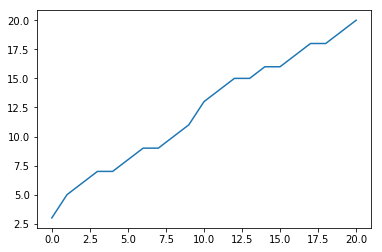

In [15]:
target_string = 'Inteligencia Artificial en la PUCP'

# construye el pool de alelos con los caracteres en mayuscula, minuscula y espacio en blanco
allele_pool = []
allele_pool.extend( [chr(x) for x in range(65, 91)] )   # caracteres ASCII en mayuscula
allele_pool.extend( [chr(x) for x in range(97, 123)] )  # caracteres ASCII en minuscula
allele_pool.extend(' ')  # espacio en blanco

# Inicializa una poblacion inicial de forma aleatoria
num_individuals = 500
population = init_population(num_individuals, len(target_string), allele_pool)

fitness_fn = matching_characters 

ngen = 20 # Nro de generaciones
pmut = 0.8 # taza de mutación

metodoSeleccion=['roulette','torneo']
size_torneo = int(5*num_individuals/100) #tamaño del torneo como porcentaje de la poblacion

crossover=['onepoint','uniform']
mutation=['position','onepoint']

# llama al algoritmo genetico
best_ind, bestfitness = genetic_algorithm(population, fitness_fn, target_string, ngen, metodoSeleccion[0],
                                          size_torneo,pmut, crossover[0], mutation[0])
                       

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()